## Home Credit Default Risk - Assignment 4

In [1]:
# References used:
# https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features
# https://www.kaggle.com/prashantkikani/home-rf-et-xgb-cb-stack-oof1-lb-0-789
# Various documentation about sklearn/fastai and other kernels on the challenge discussion

# Configuration
sample_size = None # None for full training, else number of rows, careful this will break fastai preprocessing (it fails if any test feature has NaN that did not exist with NaN in the training set)
folder = 'dataset' # data folder
load_preprocessed = True # load preprocessed data from disk to save time
fname_preprocessed = 'my_preprocessed_data.csv'

In [2]:
import os
import gc
import pandas as pd
import numpy as np
import lightgbm as lgbm
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from fastai import *
from fastai.tabular import *

df_train = pd.read_csv(folder+'/application_train.csv', nrows=sample_size)
df_test = pd.read_csv(folder+'/application_test.csv', nrows=sample_size)

df_bureau = pd.read_csv(folder+'/bureau.csv', nrows=sample_size)
df_bureau_balance = pd.read_csv(folder+'/bureau_balance.csv', nrows=sample_size)
df_credit_card = pd.read_csv(folder+'/credit_card_balance.csv', nrows=sample_size)
df_pos_cash = pd.read_csv(folder+'/POS_CASH_balance.csv', nrows=sample_size)
df_prev_app = pd.read_csv(folder+'/previous_application.csv', nrows=sample_size)
df_install = pd.read_csv(folder+'/installments_payments.csv', nrows=sample_size)
    
print(f'Training shape = {df_train.shape}')
print(f'Training shape = {df_test.shape}')
print(f'Target proportion = {round(df_train["TARGET"].mean(), 2)}')

Training shape = (307511, 122)
Training shape = (48744, 121)
Target proportion = 0.08


Target proportotion shows target column is highly imbalanced (92% vs. 8%).

## Preprocessing & Feature Engineering

In [3]:
# combine both train & test into one dataframe for preprocessing
key = 'SK_ID_CURR' # primary key
len_train = len(df_train) # length of training data 
df_both = pd.concat([df_train, df_test], sort=False) # combined train & testdataframe

if not load_preprocessed:
    # combine additional datasets into one big dataframe & engineer some features (mostly aggregations)
    print(f'Combined train & test before processing {df_both.shape}')

    # main dataframe
    print('Processing main data..')
    ## loan relative to salary
    df_both['LOAN_INCOME_RATIO'] = df_both['AMT_CREDIT'] / df_both['AMT_INCOME_TOTAL']
    ## annuities (fixed stream of payments) to income
    df_both['ANNUITY_INCOME_RATIO'] = df_both['AMT_ANNUITY'] / df_both['AMT_INCOME_TOTAL']
    ## number of days employed in life
    df_both['WORKING_LIFE_RATIO'] = df_both['DAYS_EMPLOYED'] / df_both['DAYS_BIRTH']
    ## income per family member
    df_both['INCOME_PER_FAM'] = df_both['AMT_INCOME_TOTAL'] / df_both['CNT_FAM_MEMBERS']
    ## income credit ratio
    df_both['INCOME_CREDIT_PERC'] = df_both['AMT_INCOME_TOTAL'] / df_both['AMT_CREDIT']
    ## children per household, relative to amount of familymembers
    df_both['CHILDREN_RATIO'] = df_both['CNT_CHILDREN'] / df_both['CNT_FAM_MEMBERS']
    df_merged = df_both
    print(f'\t-> {df_merged.shape}')

    # bureau
    print('Processing bureau data..')
    ## just join them, so we can use SK_ID_BUREAU in the next step
    df_merged = df_merged.merge(df_bureau, left_on=key, right_index=True, how='left', suffixes=['', '_BUR'])    
    print(f'\t-> {df_merged.shape}')

    # bureau balance
    print('Processing bureau balance..')
    most_recent_index = df_bureau_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].idxmax() # first occurence of maximum
    df_bureau_balance = df_bureau_balance.loc[most_recent_index, :]
    df_merged = df_merged.merge(df_bureau_balance, left_on='SK_ID_BUREAU', right_on='SK_ID_BUREAU', how='left', suffixes=['', '_B_B'])
    print(f'\t-> {df_merged.shape}')

    # credit card balance
    print('Processing credit card balance..')
    ## weighted average of monthly credit card balances
    wm = lambda x: np.average(x, weights=-1/df_credit_card.loc[x.index, 'MONTHS_BALANCE'])
    credit_card_avgs = df_credit_card.groupby(key).agg(wm)   
    df_merged = df_merged.merge(credit_card_avgs, left_on=key, right_index=True, how='left', suffixes=['', '_CC_WAVG'])                      
    print(f'\t-> {df_merged.shape}')

    # pos_cash
    print('Processing pos cash..')
    ## weighted positive cash balance
    wm = lambda x: np.average(x, weights=-1/df_pos_cash.loc[x.index, 'MONTHS_BALANCE'])
    cash_avg = df_pos_cash.groupby('SK_ID_CURR')['CNT_INSTALMENT','CNT_INSTALMENT_FUTURE','SK_DPD', 'SK_DPD_DEF'].agg({'CNT_INSTALMENT': wm, 'CNT_INSTALMENT_FUTURE': wm, 'SK_DPD': wm, 'SK_DPD_DEF':wm})
    print(f'\t-> {df_merged.shape}')

    # prev applications
    print('Processing previous applications..')
    ## clean up, 365243 == nan in this table
    df_prev_app['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    df_prev_app['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
    df_prev_app['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    df_prev_app['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    df_prev_app['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    df_prev_app = df_prev_app.groupby('SK_ID_CURR').agg({'SK_ID_CURR': 'count', 'AMT_CREDIT': 'sum'})
    ## we engineer 2 new columns, previous application count and total previous loans
    df_prev_app.columns = ['PREV APP COUNT', 'TOTAL PREV LOAN AMT']
    df_merged = df_merged.merge(df_prev_app, left_on='SK_ID_CURR', right_index=True, how='left')
    print(f'\t-> {df_merged.shape}')

    # installment payments
    print('Processing installments data..')         
    ## ignore
    print(f'\t-> {df_merged.shape}')

    # other value counts
    print('Adding simple value counts..')
    df_merged = df_merged.merge(pd.DataFrame(df_bureau[key].value_counts()), left_on=key, right_index=True, how='left', suffixes=['', '_CNT_BUREAU'])
    df_merged = df_merged.merge(pd.DataFrame(df_credit_card[key].value_counts()), left_on=key, right_index=True, how='left', suffixes=['', '_CNT_CRED_CARD'])
    df_merged = df_merged.merge(pd.DataFrame(df_pos_cash[key].value_counts()), left_on=key, right_index=True, how='left', suffixes=['', '_CNT_POS_CASH'])
    df_merged = df_merged.merge(pd.DataFrame(df_install[key].value_counts()), left_on=key, right_index=True, how='left', suffixes=['', '_CNT_INSTALL'])
    print(f'\t-> {df_merged.shape}')

    print(f'Combined train & test after preprocessing {df_merged.shape}')

    # save as csv & allow loading of csv for speedup 
    print(f'Saving to {fname_preprocessed}')
    df_merged.to_csv(fname_preprocessed)
else:
    df_merged = pd.read_csv(fname_preprocessed)

df_meta = pd.DataFrame()
df_meta[key] = df_merged[key]

Combined train & test before processing (356255, 122)
Processing main data..
	-> (356255, 128)
Processing bureau data..
	-> (356255, 145)
Processing bureau balance..
	-> (356255, 147)
Processing credit card balance..
	-> (356255, 168)
Processing pos cash..
	-> (356255, 168)
Processing previous applications..
	-> (356255, 170)
Processing installments data..
	-> (356255, 170)
Adding simple value counts..
	-> (356255, 174)
Combined train & test after preprocessing (356255, 174)
Saving to my_preprocessed_data.csv


Now we label encode the categorical values because fastai does not do that on its own

In [4]:
from sklearn import preprocessing 

df_proc = df_merged
cat_feats = df_proc.columns[df_proc.dtypes == 'object']

for feat in cat_feats:
    encoder = preprocessing.LabelEncoder()
    df_proc[feat] = encoder.fit_transform(df_proc[feat].fillna('NULL'))

In [5]:
df_proc.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF,PREV APP COUNT,TOTAL PREV LOAN AMT,SK_ID_CURR_CNT_BUREAU,SK_ID_CURR_CNT_CRED_CARD,SK_ID_CURR_CNT_POS_CASH,SK_ID_CURR_CNT_INSTALL
0,100002,1.0,0,1,0,1,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,1.0,179055.0,8.0,NaN,19.0,19.0
1,100003,0.0,0,0,0,0,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,3.0,1452573.0,4.0,NaN,28.0,25.0
2,100004,0.0,1,1,1,1,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,1.0,20106.0,2.0,NaN,4.0,3.0
3,100006,0.0,0,0,0,1,0,135000.0,312682.5,29686.5,...,NaN,0.0,0.0,0.0,9.0,2625259.5,NaN,6.0,21.0,16.0
4,100007,0.0,0,1,0,1,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,6.0,999832.5,1.0,NaN,66.0,66.0


## Model & Training

### FastAI

In [6]:
train = df_proc[:len_train]
test = df_proc[len_train:].drop(columns='TARGET')
target = train['TARGET']

dep_var = 'TARGET'
valid = train.sample(frac=0.2, random_state=42)
valid_idx = valid.index
procs = [FillMissing, Categorify, Normalize]

# dont normalize the key column, we dont need it either in here
data = TabularDataBunch.from_df("./", train.drop(columns=[key]), dep_var, valid_idx=valid_idx, procs=procs, bs=2048)
data.add_test(TabularList.from_df(test.drop(columns=[key]), path="./"))
data.show_batch(rows=5)

NONLIVINGAREA_MEDI_na,PREV APP COUNT_na,COMMONAREA_MEDI_na,FLOORSMIN_MEDI_na,DEF_30_CNT_SOCIAL_CIRCLE_na,DEF_60_CNT_SOCIAL_CIRCLE_na,AMT_REQ_CREDIT_BUREAU_HOUR_na,EXT_SOURCE_1_na,ENTRANCES_MEDI_na,DAYS_LAST_PHONE_CHANGE_na,YEARS_BUILD_MEDI_na,AMT_TOTAL_RECEIVABLE_na,LIVINGAREA_MODE_na,DAYS_CREDIT_ENDDATE_na,LIVINGAPARTMENTS_MODE_na,YEARS_BEGINEXPLUATATION_MEDI_na,SK_ID_CURR_CNT_INSTALL_na,ANNUITY_INCOME_RATIO_na,OWN_CAR_AGE_na,AMT_CREDIT_SUM_na,AMT_PAYMENT_CURRENT_na,TOTAL PREV LOAN AMT_na,AMT_ANNUITY_BUR_na,APARTMENTS_MODE_na,FLOORSMAX_MEDI_na,OBS_60_CNT_SOCIAL_CIRCLE_na,MONTHS_BALANCE_CC_WAVG_na,AMT_REQ_CREDIT_BUREAU_YEAR_na,FLOORSMAX_AVG_na,AMT_DRAWINGS_CURRENT_na,CHILDREN_RATIO_na,YEARS_BUILD_MODE_na,AMT_REQ_CREDIT_BUREAU_DAY_na,BASEMENTAREA_MEDI_na,LANDAREA_MEDI_na,AMT_CREDIT_LIMIT_ACTUAL_na,FLOORSMIN_AVG_na,FLOORSMIN_MODE_na,LIVINGAREA_AVG_na,COMMONAREA_MODE_na,AMT_DRAWINGS_OTHER_CURRENT_na,LIVINGAPARTMENTS_MEDI_na,NONLIVINGAPARTMENTS_MEDI_na,NONLIVINGAPARTMENTS_AVG_na,YEARS_BEGINEXPLUATATION_MODE_na,SK_ID_CURR_CNT_BUREAU_na,NONLIVINGAREA_MODE_na,CNT_DRAWINGS_ATM_CURRENT_na,ELEVATORS_MODE_na,FLOORSMAX_MODE_na,LANDAREA_MODE_na,SK_DPD_na,AMT_CREDIT_MAX_OVERDUE_na,AMT_DRAWINGS_ATM_CURRENT_na,AMT_INST_MIN_REGULARITY_na,AMT_RECIVABLE_na,SK_ID_CURR_CNT_POS_CASH_na,CNT_DRAWINGS_OTHER_CURRENT_na,LIVINGAREA_MEDI_na,APARTMENTS_MEDI_na,EXT_SOURCE_3_na,TOTALAREA_MODE_na,LIVINGAPARTMENTS_AVG_na,AMT_BALANCE_na,NONLIVINGAREA_AVG_na,OBS_30_CNT_SOCIAL_CIRCLE_na,YEARS_BUILD_AVG_na,EXT_SOURCE_2_na,APARTMENTS_AVG_na,LANDAREA_AVG_na,NONLIVINGAPARTMENTS_MODE_na,MONTHS_BALANCE_na,CNT_DRAWINGS_CURRENT_na,AMT_CREDIT_SUM_LIMIT_na,CNT_DRAWINGS_POS_CURRENT_na,CNT_FAM_MEMBERS_na,AMT_RECEIVABLE_PRINCIPAL_na,COMMONAREA_AVG_na,BASEMENTAREA_AVG_na,AMT_ANNUITY_na,SK_ID_CURR_CNT_CRED_CARD_na,DAYS_ENDDATE_FACT_na,ENTRANCES_MODE_na,BASEMENTAREA_MODE_na,AMT_REQ_CREDIT_BUREAU_WEEK_na,ENTRANCES_AVG_na,SK_DPD_DEF_na,AMT_CREDIT_SUM_DEBT_na,AMT_PAYMENT_TOTAL_CURRENT_na,AMT_GOODS_PRICE_na,AMT_REQ_CREDIT_BUREAU_QRT_na,SK_ID_PREV_na,CNT_INSTALMENT_MATURE_CUM_na,YEARS_BEGINEXPLUATATION_AVG_na,AMT_DRAWINGS_POS_CURRENT_na,ELEVATORS_AVG_na,ELEVATORS_MEDI_na,AMT_REQ_CREDIT_BUREAU_MON_na,INCOME_PER_FAM_na,NONLIVINGAREA_MEDI,CODE_GENDER,PREV APP COUNT,COMMONAREA_MEDI,FLOORSMIN_MEDI,STATUS,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_HOUR,EXT_SOURCE_1,ENTRANCES_MEDI,DAYS_LAST_PHONE_CHANGE,YEARS_BUILD_MEDI,AMT_TOTAL_RECEIVABLE,CREDIT_DAY_OVERDUE,LIVINGAREA_MODE,DAYS_CREDIT_ENDDATE,LIVINGAPARTMENTS_MODE,FLAG_DOCUMENT_15,NAME_INCOME_TYPE,FLAG_EMAIL,FLAG_DOCUMENT_3,REG_CITY_NOT_WORK_CITY,AMT_INCOME_TOTAL,WORKING_LIFE_RATIO,YEARS_BEGINEXPLUATATION_MEDI,SK_ID_CURR_CNT_INSTALL,REGION_RATING_CLIENT_W_CITY,SK_ID_CURR_BUR,ANNUITY_INCOME_RATIO,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,OWN_CAR_AGE,NAME_HOUSING_TYPE,WALLSMATERIAL_MODE,AMT_CREDIT_SUM,AMT_PAYMENT_CURRENT,TOTAL PREV LOAN AMT,AMT_CREDIT_SUM_OVERDUE,FLAG_MOBIL,AMT_ANNUITY_BUR,APARTMENTS_MODE,NAME_FAMILY_STATUS,FLOORSMAX_MEDI,FLAG_DOCUMENT_18,NAME_TYPE_SUITE,LIVE_CITY_NOT_WORK_CITY,OBS_60_CNT_SOCIAL_CIRCLE,MONTHS_BALANCE_CC_WAVG,AMT_REQ_CREDIT_BUREAU_YEAR,FLOORSMAX_AVG,FLAG_DOCUMENT_21,CNT_CHILDREN,DAYS_REGISTRATION,AMT_DRAWINGS_CURRENT,CHILDREN_RATIO,YEARS_BUILD_MODE,AMT_REQ_CREDIT_BUREAU_DAY,FLAG_DOCUMENT_13,DAYS_ID_PUBLISH,EMERGENCYSTATE_MODE,CREDIT_ACTIVE,BASEMENTAREA_MEDI,LANDAREA_MEDI,INCOME_CREDIT_PERC,FLAG_DOCUMENT_4,AMT_CREDIT_LIMIT_ACTUAL,FLOORSMIN_AVG,CNT_CREDIT_PROLONG,FLOORSMIN_MODE,LIVINGAREA_AVG,COMMONAREA_MODE,AMT_CREDIT,AMT_DRAWINGS_OTHER_CURRENT,LIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MEDI,WEEKDAY_APPR_PROCESS_START,NONLIVINGAPARTMENTS_AVG,NAME_EDUCATION_TYPE,YEARS_BEGINEXPLUATATION_MODE,FLAG_DOCUMENT_5,FLAG_PHONE,SK_ID_CURR_CNT_BUREAU,ORGANIZATION_TYPE,NONLIVINGAREA_MODE,CNT_DRAWINGS_ATM_CURRENT,ELEVATORS_MODE,REGION_POPULATION_RELATIVE,REG_CITY_NOT_LIVE_CITY,FLOORSMAX_MODE,LANDAREA_MODE,SK_DPD,AMT_CREDIT_MAX_OVERDUE,FLAG_DOCUMENT_11,AMT_DRAWINGS_ATM_CURRENT,AMT_INST_MIN_REGULARITY,FLAG_D

In [7]:
def accuracy_fixed(input:Tensor, targs:Tensor)->Rank0Tensor:
    targs = targs.view(-1).long()
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs).float().mean()

wd=0.2 # https://becominghuman.ai/this-thing-called-weight-decay-a7cd4bcfccab, 0.2 seems to work best
learn = tabular_learner(data, layers=[200,100], metrics=accuracy_fixed, wd=wd)
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy_fixed,time
0,0.083959,0.074481,0.919531,02:05
1,0.071101,0.114668,0.919531,02:04
2,0.068736,0.069540,0.919531,02:03
3,0.066910,0.551512,0.919531,02:02


In [8]:
from sklearn.metrics import roc_auc_score

valid_predicts, _ = learn.get_preds(ds_type=DatasetType.Valid)
valid_probs = np.array(valid_predicts)
valid_targets = df_train.loc[valid_idx].TARGET.values
valid_score = roc_auc_score(valid_targets, valid_probs)
print(f'AUC/ROC: {valid_score}')

preds, y = learn.get_preds(ds_type=DatasetType.Test)
out = pd.DataFrame()
out[key] = test[key]
out['TARGET'] = preds.numpy()[:, 0]
out['TARGET'] = out['TARGET'].astype('float')
out['TARGET'] = out['TARGET'].clip(lower=0, upper=1)
out.to_csv('sub_fastai.csv', index=False)
# ~74% without agg

### Other approaches (lgbm, keras, scikit,..)

In [9]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn import tree, ensemble
from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.models import Sequential
from keras import layers
import lightgbm as lgbm
import xgboost # conda install -c anaconda py-xgboost

def print_scores(y_test, preds):
    print(f'Classification: {classification_report(y_test, preds)}')
    print(f'Confusion Matrix: {confusion_matrix(y_test, preds)}')
    print(f'Accuracy: {accuracy_score(y_test,preds)}')
    print(f'ROC/AU: {roc_auc_score(y_test,  preds)}')
    
    
def create_sub(name, model, testset, test):
    y_pred = model.predict_proba(testset)[:,1]
    df_sub = pd.DataFrame()
    df_sub['SK_ID_CURR'] = test['SK_ID_CURR']
    df_sub['TARGET'] = y_pred
    df_sub['TARGET'] = df_sub['TARGET'].astype('float')
    df_sub['TARGET'] = df_sub['TARGET'].clip(lower=0, upper=1)
    df_sub.head()
    df_sub.to_csv(name, index=False)
           
# https://lightgbm.readthedocs.io/en/latest/Parameters.html
lgbm_params = {
    'boosting': 'dart', # gbdt, rf, dart, goss
    'application': 'binary', # binary, multiclassova, ..
    'metric': 'auc',
    'feature_fraction': 0.5, # default=1, randomly select part of features with each iteration, helps with overfitting
    'scale_pos_weight': 2, # default=1, exclusive with is_unbalance, increaes overall performance
    'drop_rate': 0.02, # default=0.1, dropout, used against overfitting
}

# this does not use the preprocessing from fastai
lgbm_train = lgbm.Dataset(train.drop(columns=['TARGET']), label=target, categorical_feature=cat_feats.tolist(), free_raw_data=False)

results = lgbm.cv(train_set=lgbm_train,
                     params=lgbm_params,
                     nfold=5,
                     num_boost_round=500,
                     verbose_eval=100,
                     metrics=['auc'])
opt = np.argmax(results['auc-mean'])
print(f'Best result = {np.max(results["auc-mean"])}')

clf = lgbm.train(lgbm_params, lgbm_train, num_boost_round=opt)
y_pred = clf.predict(test)
out = pd.DataFrame()
out[key] = test[key]
out['TARGET'] = y_pred
out.to_csv('sub_lgbm.csv', index=False)
# ~76% without aggregatopm
print('Feature importances:', list(clf.feature_importance()))

Using TensorFlow backend.
C:\Users\xct\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[100]	cv_agg's auc: 0.763167 + 0.00495816
[200]	cv_agg's auc: 0.764178 + 0.00499839
[300]	cv_agg's auc: 0.765714 + 0.00490112
[400]	cv_agg's auc: 0.765983 + 0.00516591
[500]	cv_agg's auc: 0.766047 + 0.00495535
Best result = 0.766229175205221


C:\Users\xct\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Feature importances: [110, 50, 111, 30, 13, 7, 99, 307, 302, 322, 20, 25, 79, 70, 38, 127, 377, 158, 180, 255, 175, 0, 3, 45, 0, 18, 1, 288, 16, 19, 75, 60, 73, 3, 3, 1, 44, 2, 2, 1433, 505, 503, 577, 48, 47, 43, 46, 41, 15, 28, 31, 31, 65, 29, 50, 31, 49, 45, 43, 57, 52, 49, 6, 26, 13, 18, 60, 54, 43, 23, 30, 36, 39, 54, 19, 37, 8, 25, 11, 10, 53, 40, 46, 18, 48, 2, 2, 57, 29, 1, 39, 67, 42, 56, 165, 0, 60, 0, 0, 2, 0, 2, 0, 0, 1, 0, 6, 5, 3, 21, 0, 23, 0, 0, 0, 5, 14, 11, 20, 70, 64, 155, 194, 209, 113, 121, 9, 96, 102, 2, 0, 115, 5, 127, 74, 41, 1, 71, 55, 27, 5, 3, 98, 52, 42, 2, 64, 64, 96, 182, 48, 41, 28, 58, 78, 57, 62, 58, 69, 27, 121, 161, 18, 30, 47, 41, 63, 124, 415, 177, 52, 287, 233]


In [10]:
# For keras models we need to deal with the imbalance manually & it helps to min-max scale

X = data.train_ds.inner_df.drop(columns=['TARGET'])
y = data.train_ds.inner_df['TARGET']

rs = RandomOverSampler(random_state=42)
X_resampled, y_resampled = rs.fit_resample(X, y)

scaler = MinMaxScaler()
X_resampled_tf = scaler.fit_transform(X_resampled)
X_train, X_test, y_train, y_test = train_test_split(X_resampled_tf, y_resampled, test_size=0.2, random_state=42)

In [13]:
def create_model():
    model = Sequential()
    model.add(Dense(200, input_dim=(271), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))
    optimizer = Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])  
    return model

clf = KerasClassifier(build_fn=create_model, epochs=20, batch_size=64, verbose=1)
pipeline = Pipeline([('clf',  clf)])
model = pipeline.fit(X_train, y_train)
print_scores(y_test, model.predict(X_test))
create_sub('sub_ann.csv', model, data.test_ds.inner_df, test)

Epoch 1/20
201472/361812 [===============>..............] - ETA: 30:48 - loss: 0.7560 - acc: 0.53 - ETA: 2:22 - loss: 0.7152 - acc: 0.5156 - ETA: 1:20 - loss: 0.7071 - acc: 0.515 - ETA: 1:02 - loss: 0.7009 - acc: 0.521 - ETA: 51s - loss: 0.6927 - acc: 0.542 - ETA: 45s - loss: 0.6888 - acc: 0.54 - ETA: 40s - loss: 0.6879 - acc: 0.55 - ETA: 37s - loss: 0.6849 - acc: 0.55 - ETA: 35s - loss: 0.6850 - acc: 0.55 - ETA: 33s - loss: 0.6840 - acc: 0.56 - ETA: 31s - loss: 0.6823 - acc: 0.56 - ETA: 30s - loss: 0.6800 - acc: 0.56 - ETA: 29s - loss: 0.6792 - acc: 0.56 - ETA: 28s - loss: 0.6779 - acc: 0.57 - ETA: 27s - loss: 0.6759 - acc: 0.57 - ETA: 27s - loss: 0.6747 - acc: 0.57 - ETA: 26s - loss: 0.6737 - acc: 0.57 - ETA: 26s - loss: 0.6716 - acc: 0.58 - ETA: 25s - loss: 0.6690 - acc: 0.58 - ETA: 25s - loss: 0.6680 - acc: 0.58 - ETA: 24s - loss: 0.6671 - acc: 0.59 - ETA: 24s - loss: 0.6660 - acc: 0.59 - ETA: 24s - loss: 0.6660 - acc: 0.59 - ETA: 23s - loss: 0.6645 - acc: 0.59 - ETA: 23s - loss: 0

In [14]:
clf = ensemble.RandomForestClassifier(criterion='entropy', n_estimators=100, max_depth=15, min_samples_leaf=5)
clf.fit(X_train, y_train)
print_scores(y_test, clf.predict(X_test))
# the roc/au score is wrong here for some reason (way lower in reality)
create_sub('sub_rf.csv', clf, data.test_ds.inner_df, test)

Classification:               precision    recall  f1-score   support

         0.0       0.87      0.81      0.84     45171
         1.0       0.83      0.88      0.85     45283

    accuracy                           0.85     90454
   macro avg       0.85      0.85      0.85     90454
weighted avg       0.85      0.85      0.85     90454

Confusion Matrix: [[36794  8377]
 [ 5344 39939]]
Accuracy: 0.8483096380480686
ROC/AU: 0.8482678875699079


## Blends

In [17]:
def merge_dataframes(dfs, merge_keys):
    dfs_merged = reduce(lambda left,right: pd.merge(left, right, on=merge_keys), dfs)
    return dfs_merged

M1 = pd.read_csv('sub_fastai.csv')
M2 = pd.read_csv('sub_lgbm.csv')
M3 = pd.read_csv('sub_ann.csv')
M4 = pd.read_csv('sub_rf.csv')

dfs = [M1,M2,M3,M4]
merge_keys=['SK_ID_CURR']
df_blend = merge_dataframes(dfs, merge_keys=merge_keys)
df_blend.columns = ['SK_ID_CURR','T1','T2','T3','T4']

prob_preds = 0.2 * df_blend['T1'] + 0.8 * df_blend['T2'] #+ 0.2 * df_blend['T3'] + 0.2 * df_blend['T4']

sub_blend = pd.DataFrame()
sub_blend['SK_ID_CURR'] = df_blend['SK_ID_CURR']
sub_blend['TARGET']= prob_preds
sub_blend.head()
sub_blend.to_csv('sub_blend.csv', index=False)

The fastai model, which was scoring lower than the lgbm model helped to increase its score on submission slightly.

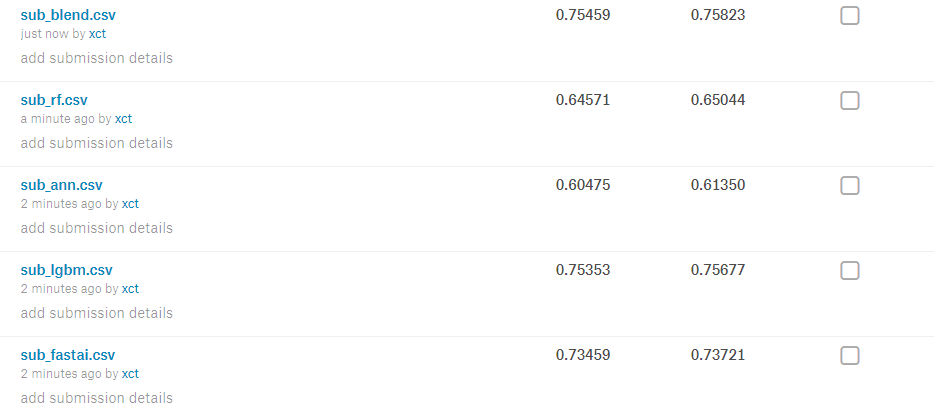

The scores are not impressive, but it was a good way to learn about how to appaoch kaggle challenges.